In [1]:
import pandas as pd

train = pd.read_csv('./data/cat_in_the_dat/train.csv')  
test = pd.read_csv('./data/cat_in_the_dat/test.csv')  

test_id = test['id']
del train['id']
del test['id']

# No missing value

# preprocessing

In [2]:
def change_column_dtype_to_object(name):
    train[name] = train[name].astype('object')
    test[name] = test[name].astype('object')

In [3]:
# Since day and month is the date of the data point, I will regard them as categorical variable
change_column_dtype_to_object("day")
change_column_dtype_to_object("month")

In [4]:
# Some of the categorical columns are int type,convert them into object type
change_column_dtype_to_object("bin_0")
change_column_dtype_to_object("bin_1")
change_column_dtype_to_object("bin_2")
change_column_dtype_to_object("ord_0")

## Categorical column encoding

In [5]:
import numpy as np

In [6]:
cat_col_list = train.dtypes[train.dtypes == object].index.tolist()

# Unseen test categorical column values
solution: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [8]:
#record the original value 
cat_col_ref_dict  = {}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoderExt()
for i in cat_col_list:
    print("processing %s" % i)
    le.fit(train[i])
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])
    cat_col_ref_dict.update({i : le.classes_})

processing bin_0


C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


processing bin_1
processing bin_2
processing bin_3
processing bin_4
processing nom_0
processing nom_1
processing nom_2
processing nom_3
processing nom_4
processing nom_5
processing nom_6
processing nom_7
processing nom_8
processing nom_9
processing ord_0
processing ord_1
processing ord_2
processing ord_3
processing ord_4
processing ord_5
processing day
processing month


In [9]:
#making sure those cateogrical variables are dtype "int32"
#and use label encoding
for col in cat_col_list:
    train[col] = train[col].astype('int32')
    test[col] = test[col].astype('int32')

# Modeling using partial of training data

In [10]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [11]:
X = train.drop(['target'], axis=1)
y = train[['target']]

In [12]:
from sklearn.model_selection import train_test_split

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, train_size=0.75, random_state=1337,stratify=y_train_and_val)

In [13]:
import numpy as np
import lightgbm as lgb

In [14]:
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                        free_raw_data=False)

In [15]:
num_train, num_feature = X_train.shape

In [16]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train.columns.tolist()

In [17]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [18]:
categorical_features_indices

array([], dtype=int64)

In [19]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'verbose': 0
}

In [20]:
evals_result = {}  # to record eval results for plotting

In [21]:
%%time
print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...


C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\willy\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.607606
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.600825
[3]	valid_0's binary_logloss: 0.595136
[4]	valid_0's binary_logloss: 0.590141
[5]	valid_0's binary_logloss: 0.585947
[6]	valid_0's binary_logloss: 0.581978
[7]	valid_0's binary_logloss: 0.578414
[8]	valid_0's binary_logloss: 0.575362
[9]	valid_0's binary_logloss: 0.572586
[10]	valid_0's binary_logloss: 0.569902
[11]	valid_0's binary_logloss: 0.567495
[12]	valid_0's binary_logloss: 0.565351
[13]	valid_0's binary_logloss: 0.563437
[14]	valid_0's binary_logloss: 0.561812
[15]	valid_0's binary_logloss: 0.560188
[16]	valid_0's binary_logloss: 0.558653
[17]	valid_0's binary_logloss: 0.557387
[18]	valid_0's binary_logloss: 0.556068
[19]	valid_0's binary_logloss: 0.554864
[20]	valid_0's binary_logloss: 0.553806
[21]	valid_0's binary_logloss: 0.552829
[22]	valid_0's binary_logloss: 0.551811
[23]	valid_0's binary_logloss: 0.550982
[24]	valid_0's binary_loglo

[203]	valid_0's binary_logloss: 0.528482
[204]	valid_0's binary_logloss: 0.52848
[205]	valid_0's binary_logloss: 0.528463
[206]	valid_0's binary_logloss: 0.528502
[207]	valid_0's binary_logloss: 0.528513
[208]	valid_0's binary_logloss: 0.528521
[209]	valid_0's binary_logloss: 0.528534
[210]	valid_0's binary_logloss: 0.528547
[211]	valid_0's binary_logloss: 0.528527
[212]	valid_0's binary_logloss: 0.528511
[213]	valid_0's binary_logloss: 0.528534
[214]	valid_0's binary_logloss: 0.528536
[215]	valid_0's binary_logloss: 0.528541
[216]	valid_0's binary_logloss: 0.52854
[217]	valid_0's binary_logloss: 0.528527
[218]	valid_0's binary_logloss: 0.52852
[219]	valid_0's binary_logloss: 0.528519
[220]	valid_0's binary_logloss: 0.52849
[221]	valid_0's binary_logloss: 0.5285
[222]	valid_0's binary_logloss: 0.528485
[223]	valid_0's binary_logloss: 0.52847
[224]	valid_0's binary_logloss: 0.528454
[225]	valid_0's binary_logloss: 0.528435
[226]	valid_0's binary_logloss: 0.528385
[227]	valid_0's binary_

[404]	valid_0's binary_logloss: 0.527779
[405]	valid_0's binary_logloss: 0.527789
[406]	valid_0's binary_logloss: 0.527798
[407]	valid_0's binary_logloss: 0.527782
[408]	valid_0's binary_logloss: 0.527781
[409]	valid_0's binary_logloss: 0.527748
[410]	valid_0's binary_logloss: 0.527776
[411]	valid_0's binary_logloss: 0.527745
[412]	valid_0's binary_logloss: 0.527751
[413]	valid_0's binary_logloss: 0.527772
[414]	valid_0's binary_logloss: 0.527779
[415]	valid_0's binary_logloss: 0.527784
[416]	valid_0's binary_logloss: 0.527784
[417]	valid_0's binary_logloss: 0.52778
[418]	valid_0's binary_logloss: 0.527783
[419]	valid_0's binary_logloss: 0.527773
[420]	valid_0's binary_logloss: 0.527794
[421]	valid_0's binary_logloss: 0.527789
[422]	valid_0's binary_logloss: 0.527795
[423]	valid_0's binary_logloss: 0.527796
[424]	valid_0's binary_logloss: 0.527765
[425]	valid_0's binary_logloss: 0.527772
[426]	valid_0's binary_logloss: 0.527781
[427]	valid_0's binary_logloss: 0.527785
[428]	valid_0's b

In [22]:
# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

Feature names: ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
Feature importances: [0, 0, 0, 120, 135, 275, 510, 420, 487, 378, 1965, 1746, 1401, 1407, 1324, 0, 443, 617, 775, 922, 1445, 0, 0]


feature importance plot

In [23]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


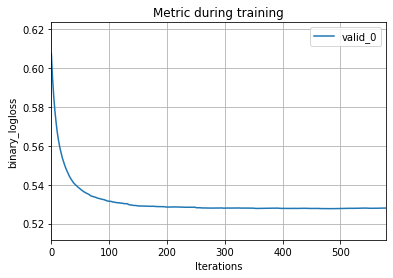

In [24]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


Plotting feature importances...


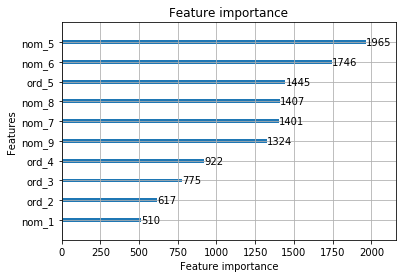

In [25]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

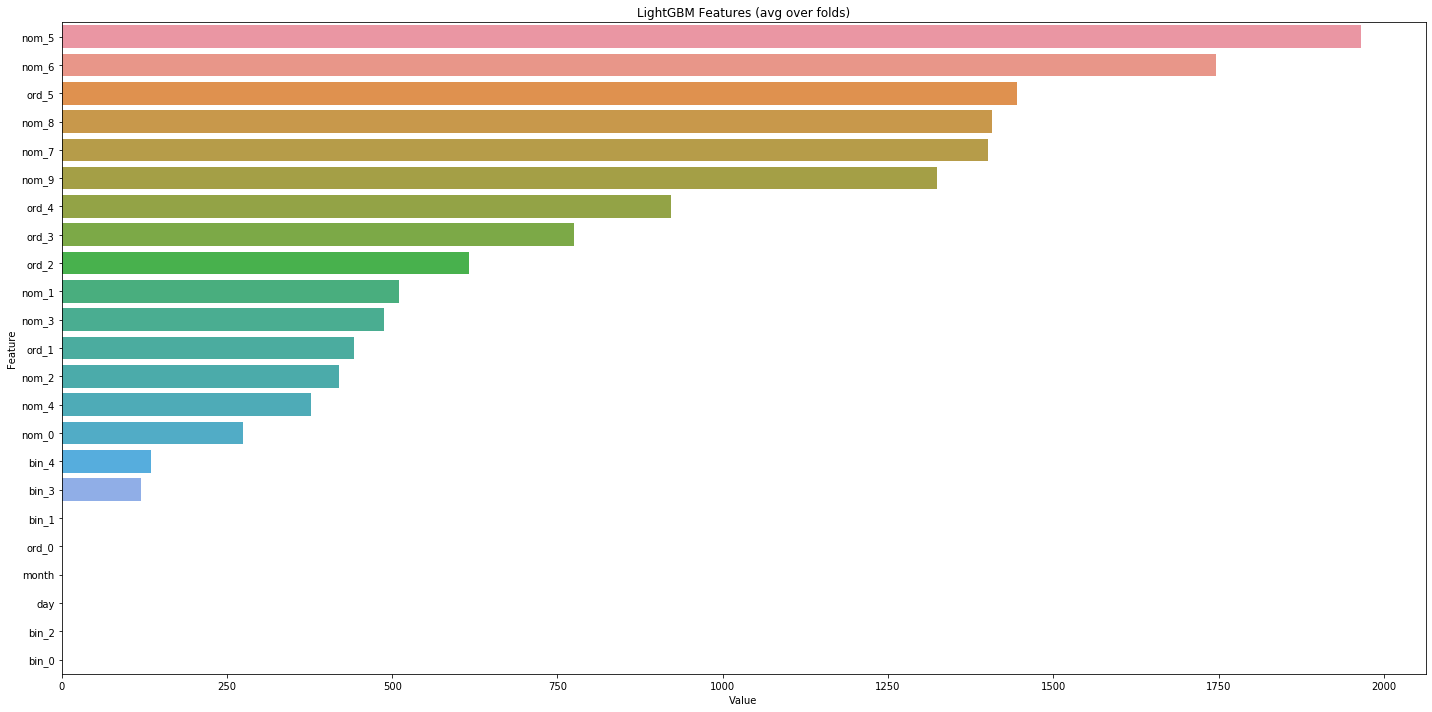

In [26]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# AUC score using small part of training data for evaluation

In [27]:
predictions_probs = gbm.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [28]:
threshold = 0.4 # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

In [29]:
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0. 1.]
Occurrence Count :  [53412 21588]


In [30]:
from sklearn import metrics

In [31]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs, pos_label=1)

In [32]:
roc_auc = metrics.auc(fpr, tpr)

In [33]:
lgb_auc = metrics.roc_auc_score(y_test, pos_probs)

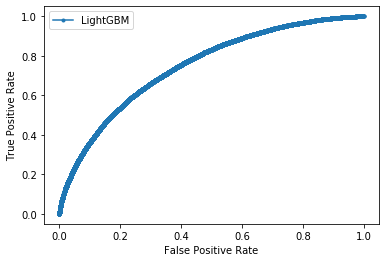

In [34]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [35]:
lgb_auc

0.7482858343189875

# Modeling using all training data to predict test data

In [36]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [37]:
X = train.drop(['target'], axis=1)
y = train[['target']]

In [38]:
from sklearn.model_selection import train_test_split

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)


In [39]:
lgb_train = lgb.Dataset(X_train_sub, y_train_sub,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val_sub, y_val_sub, reference=lgb_train,
                        free_raw_data=False)

In [40]:
num_train, num_feature = X_train_sub.shape

In [41]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train_sub.columns.tolist()

In [42]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [43]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [44]:
evals_result = {}  # to record eval results for plotting

In [54]:
%%time
print('Starting training...')
# feature_name and categorical_feature
final_model = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...


C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.611576
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.607852
[3]	valid_0's binary_logloss: 0.604762
[4]	valid_0's binary_logloss: 0.602005
[5]	valid_0's binary_logloss: 0.599359
[6]	valid_0's binary_logloss: 0.596481
[7]	valid_0's binary_logloss: 0.593991
[8]	valid_0's binary_logloss: 0.591487
[9]	valid_0's binary_logloss: 0.589486
[10]	valid_0's binary_logloss: 0.587351
[11]	valid_0's binary_logloss: 0.585253
[12]	valid_0's binary_logloss: 0.583602
[13]	valid_0's binary_logloss: 0.581843
[14]	valid_0's binary_logloss: 0.580024
[15]	valid_0's binary_logloss: 0.578297
[16]	valid_0's binary_logloss: 0.576755
[17]	valid_0's binary_logloss: 0.575279
[18]	valid_0's binary_logloss: 0.573899
[19]	valid_0's binary_logloss: 0.572625
[20]	valid_0's binary_logloss: 0.571351
[21]	valid_0's binary_logloss: 0.570132
[22]	valid_0's binary_logloss: 0.568962
[23]	valid_0's binary_logloss: 0.567849
[24]	valid_0's binary_loglo

[203]	valid_0's binary_logloss: 0.531415
[204]	valid_0's binary_logloss: 0.531405
[205]	valid_0's binary_logloss: 0.531361
[206]	valid_0's binary_logloss: 0.53131
[207]	valid_0's binary_logloss: 0.531286
[208]	valid_0's binary_logloss: 0.53128
[209]	valid_0's binary_logloss: 0.531234
[210]	valid_0's binary_logloss: 0.531205
[211]	valid_0's binary_logloss: 0.531196
[212]	valid_0's binary_logloss: 0.531194
[213]	valid_0's binary_logloss: 0.531154
[214]	valid_0's binary_logloss: 0.531111
[215]	valid_0's binary_logloss: 0.531093
[216]	valid_0's binary_logloss: 0.531056
[217]	valid_0's binary_logloss: 0.531016
[218]	valid_0's binary_logloss: 0.530852
[219]	valid_0's binary_logloss: 0.53083
[220]	valid_0's binary_logloss: 0.530748
[221]	valid_0's binary_logloss: 0.530741
[222]	valid_0's binary_logloss: 0.530716
[223]	valid_0's binary_logloss: 0.5307
[224]	valid_0's binary_logloss: 0.530681
[225]	valid_0's binary_logloss: 0.53067
[226]	valid_0's binary_logloss: 0.530664
[227]	valid_0's binary

[404]	valid_0's binary_logloss: 0.527533
[405]	valid_0's binary_logloss: 0.527422
[406]	valid_0's binary_logloss: 0.527395
[407]	valid_0's binary_logloss: 0.527371
[408]	valid_0's binary_logloss: 0.527359
[409]	valid_0's binary_logloss: 0.527352
[410]	valid_0's binary_logloss: 0.527341
[411]	valid_0's binary_logloss: 0.527339
[412]	valid_0's binary_logloss: 0.527334
[413]	valid_0's binary_logloss: 0.527322
[414]	valid_0's binary_logloss: 0.527327
[415]	valid_0's binary_logloss: 0.527321
[416]	valid_0's binary_logloss: 0.527319
[417]	valid_0's binary_logloss: 0.527322
[418]	valid_0's binary_logloss: 0.527318
[419]	valid_0's binary_logloss: 0.527323
[420]	valid_0's binary_logloss: 0.527314
[421]	valid_0's binary_logloss: 0.527291
[422]	valid_0's binary_logloss: 0.527274
[423]	valid_0's binary_logloss: 0.52725
[424]	valid_0's binary_logloss: 0.527231
[425]	valid_0's binary_logloss: 0.527231
[426]	valid_0's binary_logloss: 0.527185
[427]	valid_0's binary_logloss: 0.527172
[428]	valid_0's b

[605]	valid_0's binary_logloss: 0.526307
[606]	valid_0's binary_logloss: 0.526307
[607]	valid_0's binary_logloss: 0.526309
[608]	valid_0's binary_logloss: 0.526307
[609]	valid_0's binary_logloss: 0.526314
[610]	valid_0's binary_logloss: 0.526314
[611]	valid_0's binary_logloss: 0.526309
[612]	valid_0's binary_logloss: 0.526304
[613]	valid_0's binary_logloss: 0.526301
[614]	valid_0's binary_logloss: 0.526303
[615]	valid_0's binary_logloss: 0.526315
[616]	valid_0's binary_logloss: 0.526306
[617]	valid_0's binary_logloss: 0.526306
[618]	valid_0's binary_logloss: 0.5263
[619]	valid_0's binary_logloss: 0.526298
[620]	valid_0's binary_logloss: 0.526303
[621]	valid_0's binary_logloss: 0.526301
[622]	valid_0's binary_logloss: 0.526303
[623]	valid_0's binary_logloss: 0.526304
[624]	valid_0's binary_logloss: 0.526309
[625]	valid_0's binary_logloss: 0.526309
[626]	valid_0's binary_logloss: 0.526318
[627]	valid_0's binary_logloss: 0.526316
[628]	valid_0's binary_logloss: 0.526309
[629]	valid_0's bi

[807]	valid_0's binary_logloss: 0.525877
[808]	valid_0's binary_logloss: 0.52588
[809]	valid_0's binary_logloss: 0.52588
[810]	valid_0's binary_logloss: 0.525878
[811]	valid_0's binary_logloss: 0.525885
[812]	valid_0's binary_logloss: 0.525889
[813]	valid_0's binary_logloss: 0.525891
[814]	valid_0's binary_logloss: 0.525884
[815]	valid_0's binary_logloss: 0.525887
[816]	valid_0's binary_logloss: 0.525889
[817]	valid_0's binary_logloss: 0.525894
[818]	valid_0's binary_logloss: 0.525892
[819]	valid_0's binary_logloss: 0.5259
[820]	valid_0's binary_logloss: 0.525906
[821]	valid_0's binary_logloss: 0.525907
[822]	valid_0's binary_logloss: 0.525906
[823]	valid_0's binary_logloss: 0.525908
[824]	valid_0's binary_logloss: 0.525905
[825]	valid_0's binary_logloss: 0.525903
[826]	valid_0's binary_logloss: 0.525909
[827]	valid_0's binary_logloss: 0.525914
[828]	valid_0's binary_logloss: 0.525918
[829]	valid_0's binary_logloss: 0.525918
[830]	valid_0's binary_logloss: 0.525913
[831]	valid_0's bina

In [46]:
# feature names
print('Feature names:', final_model.feature_name())

# feature importances
print('Feature importances:', list(final_model.feature_importance()))

Feature names: ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month']
Feature importances: [0, 0, 0, 220, 304, 613, 1030, 952, 1020, 810, 4067, 3609, 3104, 2955, 2697, 0, 1019, 1219, 1613, 1883, 2825, 0, 0]


feature importance plot

In [47]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


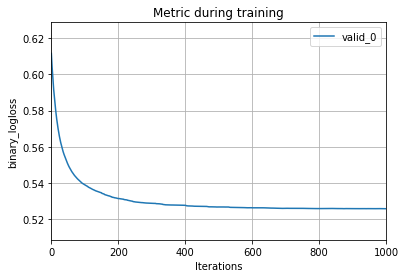

In [48]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


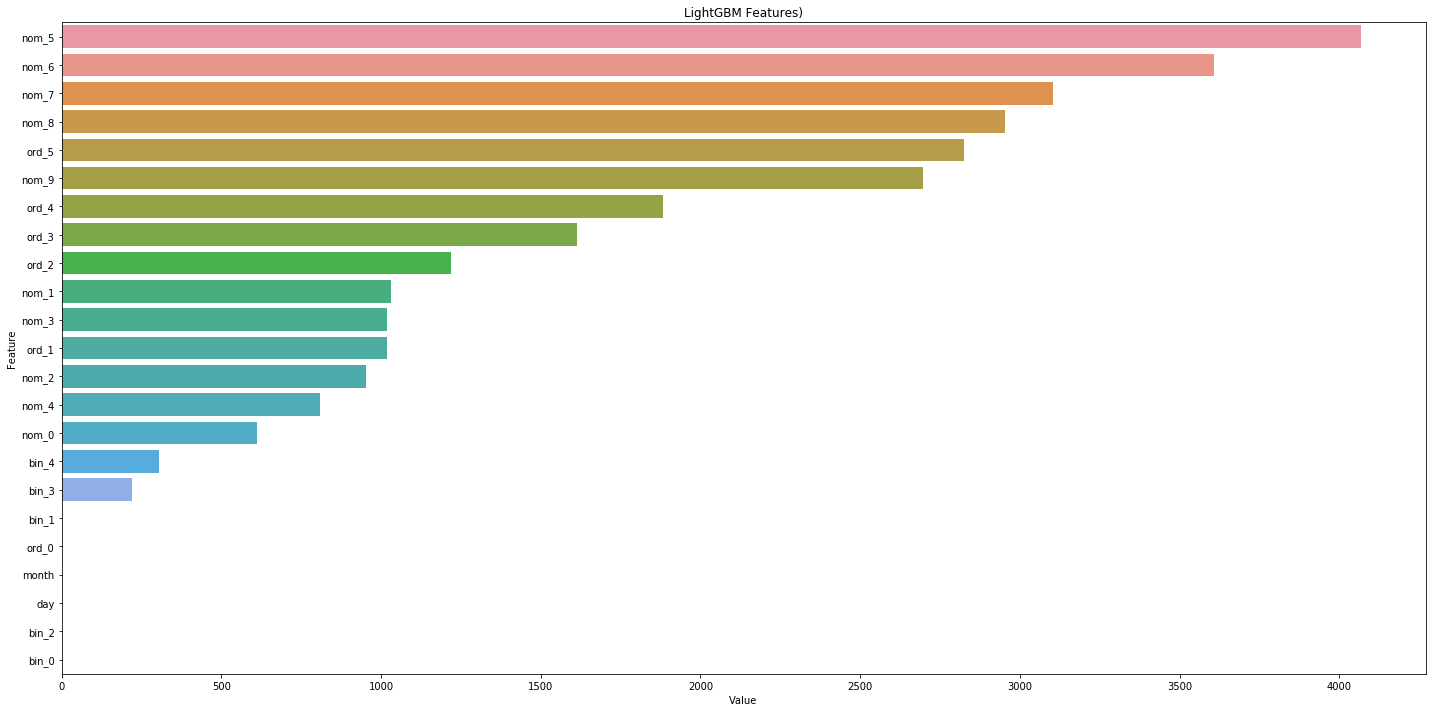

In [55]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# Test dataset for submission

In [50]:
X_test = test
# y_test = test['Survived']

In [51]:
predictions_probs = final_model.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [52]:
pos_probs.shape

(200000,)

# Submission file

In [53]:
resultdf = pd.DataFrame(columns=['id', 'target'])

In [54]:
resultdf['id'] = test_id
resultdf['target'] = pos_probs

In [57]:
resultdf.to_csv('./output/cat_in_the_dat/submission(lgb auc on self-test=0.7482858343189875).csv',index=False)

In [56]:
# submit on https://www.kaggle.com/c/cat-in-the-dat, public AUC = 0.75300, private AUC = 0.75086